In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

df= pd.read_csv(filepath_or_buffer='estaciones_meteorol.csv', sep=',')
df_resistencia_completo= df[df['NAME']=='RESISTENCIA AERO, AR' ].copy()


In [2]:
# Cargando los datos de escalado guardados previamente
scaler_TMAX = joblib.load('scaler_TMAX.pkl')
scaler_TAVG = joblib.load('scaler_TAVG.pkl')
scaler_TMIN = joblib.load('scaler_TMIN.pkl')
scaler_TAVG_doble_salida = joblib.load('scaler_TAVG_doble_salida.pkl')
scaler_TMIN_PRED_TAVG = joblib.load('scaler_TMIN_PRED_TAVG.pkl')
scaler_TMAX_PRED_TAVG = joblib.load('scaler_TMAX_PRED_TAVG.pkl')

#cargando los datos de entrenamiento guardados previamente de los modelos
SVR_TAVG= joblib.load('svr_TAVG.pkl')
SVR_TMIN= joblib.load('svr_TMIN.pkl')
SVR_TMAX= joblib.load('svr_TMAX.pkl')
SVR_TAVG_doble_salida = joblib.load('SVR_TAVG_doble_salida.pkl')
SVR_TMIN_PRED_TAVG = joblib.load('SVR_TMIN_PRED_TAVG.pkl')
SVR_TMAX_PRED_TAVG = joblib.load('SVR_TMAX_PRED_TAVG.pkl')

In [3]:
def rellenar_valores_faltantes(df):

    #se agrega esta nueva columna que después la eliminaremos 
    df['llovio'] = df['PRCP'].apply(lambda x: 1 if x > 0 else 0)

    # Para las celdas que solo tengamos TMIN como valor
    mask_TMIN_PRED_TAVG = df['TAVG'].isnull() & df['TMIN'].notnull() & df['TMAX'].isnull()

    #verificamos que tenga por lo menos un valor en el if siguiente:
    if mask_TMIN_PRED_TAVG.any():
        # Escalar los datos
        datos_TMIN_PRED_TAVG = df.loc[mask_TMIN_PRED_TAVG, [ 'TMIN','llovio']]
        datos_TMIN_PRED_TAVG_escalados = scaler_TMIN_PRED_TAVG.transform(datos_TMIN_PRED_TAVG)  # Escala TMIN para predecir TAVG
        df.loc[mask_TMIN_PRED_TAVG, 'TAVG'] = SVR_TMIN_PRED_TAVG.predict(datos_TMIN_PRED_TAVG_escalados)

    # Para las celdas que solo tengamos TMAX como valor
    mask_TMAX_PRED_TAVG = df['TAVG'].isnull() & df['TMIN'].isnull() & df['TMAX'].notnull()

    #verificamos que tenga por lo menos un valor en el if siguiente:
    if mask_TMAX_PRED_TAVG.any():
        # Escalar los datos
        datos_TMAX_PRED_TAVG = df.loc[mask_TMAX_PRED_TAVG, [ 'TMAX','llovio']]
        datos_TMAX_PRED_TAVG_escalados = scaler_TMAX_PRED_TAVG.transform(datos_TMAX_PRED_TAVG)  # Escala TMAX para predecir TAVG
        df.loc[mask_TMAX_PRED_TAVG, 'TAVG'] = SVR_TMAX_PRED_TAVG.predict(datos_TMAX_PRED_TAVG_escalados)

    # Para las celdas que solo tengamos TAVG como valor
    mask_TAVG_doble_salida = df['TAVG'].notnull() & df['TMIN'].isnull() & df['TMAX'].isnull()

    #verificamos que tenga por lo menos un valor en el if siguiente:
    if mask_TAVG_doble_salida.any():
        # Escalar los datos
        datos_TAVG_doble_salida = df.loc[mask_TAVG_doble_salida, [ 'TAVG','llovio']]
        datos_TAVG_doble_salida = scaler_TAVG_doble_salida.transform(datos_TAVG_doble_salida)  # Escala TAVG para predecir TMAX y TMIN

        df.loc[mask_TAVG_doble_salida, 'TMAX'] = SVR_TAVG_doble_salida.predict(datos_TAVG_doble_salida)[:,0]
        df.loc[mask_TAVG_doble_salida, 'TMIN'] = SVR_TAVG_doble_salida.predict(datos_TAVG_doble_salida)[:,1]


    # Para las celdas que tengamos TMAX y TMIN para predecir TAVG
    mask_TAVG = df['TAVG'].isnull() & df['TMIN'].notnull() & df['TMAX'].notnull()
    if mask_TAVG.any():
        # Escalar los datos
        datos_TAVG = df.loc[mask_TAVG, ['TMAX', 'TMIN','llovio']]
        datos_TAVG_escalados = scaler_TAVG.transform(datos_TAVG)  # Escala TMIN y TMAX para predecir TAVG
        df.loc[mask_TAVG, 'TAVG'] = SVR_TAVG.predict(datos_TAVG_escalados)

    # Para las celdas que tengamos TAVG y TMIN para predecir TMAX
    mask_TMAX = df['TMAX'].isnull() & df['TMIN'].notnull() & df['TAVG'].notnull()
    if mask_TMAX.any():
        # Escalar los datos
        datos_TMAX = df.loc[mask_TMAX, ['TAVG', 'TMIN','llovio']]
        datos_TMAX_escalados = scaler_TMAX.transform(datos_TMAX)  # Escala TAVG y TMIN para predecir TMAX
        df.loc[mask_TMAX, 'TMAX'] = SVR_TMAX.predict(datos_TMAX_escalados)

    # Para las celdas que tengamos TAVG y TMAX para predecir TMIN
    mask_TMIN = df['TMIN'].isnull() & df['TMAX'].notnull() & df['TAVG'].notnull()
    if mask_TMIN.any():
        # Escalar los datos
        datos_TMIN = df.loc[mask_TMIN, ['TAVG', 'TMAX','llovio']]
        datos_TMIN_escalados = scaler_TMIN.transform(datos_TMIN)  # Escala TAVG y TMAX para predecir TMIN
        df.loc[mask_TMIN, 'TMIN'] = SVR_TMIN.predict(datos_TMIN_escalados)
    df=df.drop(columns=['llovio'])
    return df


df_resistencia_rellenado = rellenar_valores_faltantes(df_resistencia_completo.copy())
df_resistencia_rellenado.head(10)

,Unnamed: 0,NAME,DATE,PRCP,TAVG,TMAX,TMIN
28574,28575,"RESISTENCIA AERO, AR",1980-01-01,0.0,19.6,25.8,11.0
28575,28576,"RESISTENCIA AERO, AR",1980-01-02,0.0,20.8,28.1,13.4
28576,28577,"RESISTENCIA AERO, AR",1980-01-03,0.0,22.7,30.7,14.0
28577,28578,"RESISTENCIA AERO, AR",1980-01-04,153.9,24.8,32.8,15.2
28578,28579,"RESISTENCIA AERO, AR",1980-01-05,0.0,23.4,33.2,20.8
28579,28580,"RESISTENCIA AERO, AR",1980-01-06,14.0,26.2,32.4,20.2
28580,28581,"RESISTENCIA AERO, AR",1980-01-07,0.0,26.3,33.6,20.2
28581,28582,"RESISTENCIA AERO, AR",1980-01-08,26.9,24.5,30.8,18.6
28582,28583,"RESISTENCIA AERO, AR",1980-01-09,0.0,25.5,31.7,21.0
28583,28584,"RESISTENCIA AERO, AR",1980-01-10,0.0,25.7,32.6,20.5


In [4]:
print(f'cantidad de datos faltantes antes del proceso de imputación por machine learning: \n{df_resistencia_completo.isnull().sum()}')

print(f'cantidad de datos faltantes luego del proceso de imputación por machine learning: \n{df_resistencia_rellenado.isnull().sum()}')

cantidad de datos faltantes antes del proceso de imputación por machine learning: 
Unnamed: 0       0
NAME             0
DATE             0
PRCP          6901
TAVG            41
TMAX          4315
TMIN          1935
dtype: int64
cantidad de datos faltantes luego del proceso de imputación por machine learning: 
Unnamed: 0       0
NAME             0
DATE             0
PRCP          6901
TAVG             0
TMAX             0
TMIN             0
dtype: int64


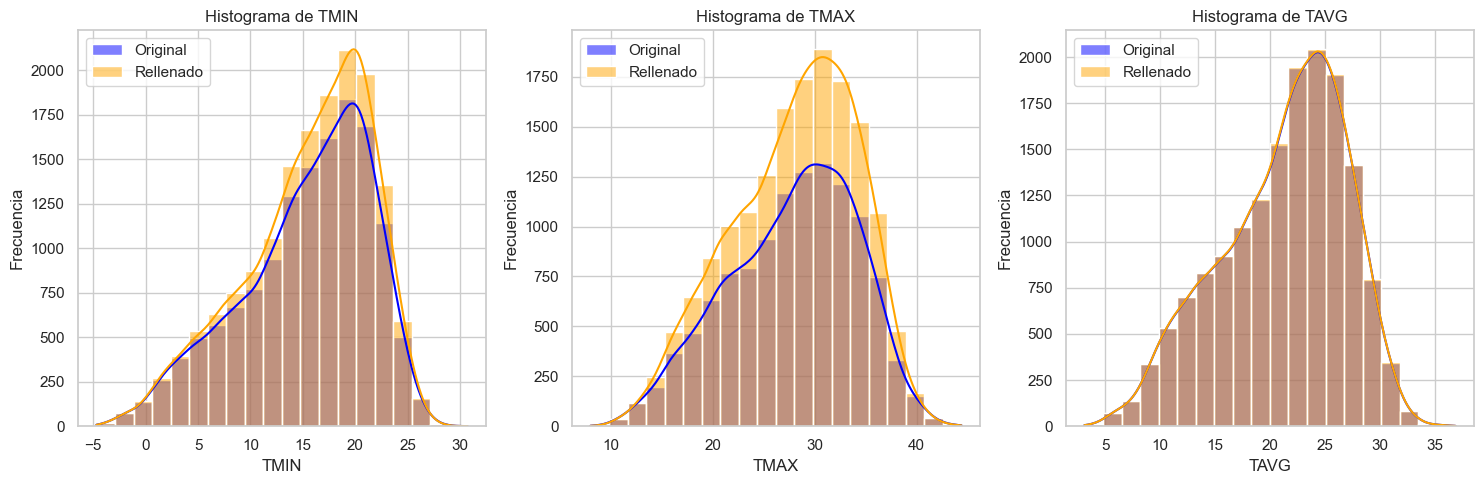

In [5]:

# Asumiendo que ya tienes df_resistencia_completo y df_resistencia_rellenado
sns.set(style="whitegrid")
plt.figure(figsize=(15, 5))

# Histograma para TMIN
plt.subplot(1, 3, 1)
sns.histplot(df_resistencia_completo['TMIN'], bins=20, kde=True, color='blue', alpha=0.5, label='Original')
sns.histplot(df_resistencia_rellenado['TMIN'], bins=20, kde=True, color='orange', alpha=0.5, label='Rellenado')
plt.title('Histograma de TMIN')
plt.xlabel('TMIN')
plt.ylabel('Frecuencia')
plt.legend()

# Histograma para TMAX
plt.subplot(1, 3, 2)
sns.histplot(df_resistencia_completo['TMAX'], bins=20, kde=True, color='blue', alpha=0.5, label='Original')
sns.histplot(df_resistencia_rellenado['TMAX'], bins=20, kde=True, color='orange', alpha=0.5, label='Rellenado')
plt.title('Histograma de TMAX')
plt.xlabel('TMAX')
plt.ylabel('Frecuencia')
plt.legend()

# Histograma para TAVG
plt.subplot(1, 3, 3)
sns.histplot(df_resistencia_completo['TAVG'], bins=20, kde=True, color='blue', alpha=0.5, label='Original')
sns.histplot(df_resistencia_rellenado['TAVG'], bins=20, kde=True, color='orange', alpha=0.5, label='Rellenado')
plt.title('Histograma de TAVG')
plt.xlabel('TAVG')
plt.ylabel('Frecuencia')
plt.legend()

# Mostrar los histogramas
plt.tight_layout()
plt.show()

In [6]:
df_resistencia_rellenado.to_csv('estaciones_meteorologicas_rellenado.csv', index=False)